# Film Genre Classification by Script Dialog Analysis

The dataset compiled by Cristian Danescu-Niculescu-Mizil, assistant professor at the department of information science of the Cornell University, offers structured data reflecting the dialog corpus of 617 movies, additional meta information about them, such as title, genres, IMDB votes and rating, as well as details from every character intervening in the movie: name, gender, character’s importance according to the position in the credits. This dataset can be found here:  http://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html

This data allows us to build a language model by processing the dialogs contained in the corpus, we hope to discern patterns that will allow us, for example, to predict the details of an unknown movie character given his or her lines in the script. Other possible applications would be classifying a new movie by genres by inputting the conversations. These are two possibilities derived from learning from the available corpus, if time allows it, we can even augment the existing data structure to infer more insights, i.e. relationship between characters, etc..

### Import third party libraries

In [50]:
%matplotlib inline
import warnings
import html2text
from urllib.request import urlopen 
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import seaborn as sns


### Transform original txt files into CSV

The dataset offered by Cristian Cornell are 4 different txt files: `movie_titles_metadata.txt`, `movie_lines.txt`, `movie_conversations.txt` and `movie_characters_metadata.txt`. To make it easier to work with the data, we will transform them into CSV files.

In [2]:
def csv_convert(filepath, header):
    with open(filepath, 'r', errors='ignore') as f:
        lines = f.readlines()
        csv = open(filepath.replace(".txt", ".csv"),"w+")
        csv.write("%s\n" %(",".join(header)))
        
        for line in lines:
            lineArray = line.split(" +++$+++ ")
            
            if "LineIDs" in header:
                lineArray[3] = '"' + lineArray[3].replace("\n", "") + '"\n'
            
            if "Line" in header:
                lineArray[4] = '"' + lineArray[4].replace('"', "'").replace("\n", "") + '"\n'

            if "Movie Title" in header:
                lineArray[3] = '"' + lineArray[3] + '"'
                
            if "Title" in header:
                lineArray[1] = '"' + lineArray[1] + '"'
                
            if "Genres" in header:
                lineArray[5] = '"' + lineArray[5].replace("\n", "") + '"\n'
                
            line = ",".join(lineArray)
            
            csv.write(line)
        
        csv.close()
    f.close()

header = ["ID", "Name", "Movie ID", "Movie Title", "Gender", "Relevance"]
csv_convert("originals/movie_characters_metadata.txt", header)

header = ["Char1 ID", "Char2 ID", "Movie ID", "LineIDs"]
csv_convert("originals/movie_conversations.txt", header)

header = ["ID", "Characted ID", "Movie ID", "Character Name", "Line"]
csv_convert("originals/movie_lines.txt", header)

header = ["ID", "Title", "Release Year", "Rating", "Votes", "Genres"]
csv_convert("originals/movie_titles_metadata.txt", header)


### Data Analysis

#### Characters Metadata

In [3]:
characters_meta = pd.read_csv('originals/movie_characters_metadata.csv', encoding='latin-1')
characters_meta.shape

(9035, 6)

In [4]:
characters_meta.head()

,ID,Name,Movie ID,Movie Title,Gender,Relevance
0,u0,BIANCA,m0,10 things i hate about you,f,4
1,u1,BRUCE,m0,10 things i hate about you,?,?
2,u2,CAMERON,m0,10 things i hate about you,m,3
3,u3,CHASTITY,m0,10 things i hate about you,?,?
4,u4,JOEY,m0,10 things i hate about you,m,6


#### Movie Conversations

In [5]:
movie_conversations = pd.read_csv('originals/movie_characters_metadata.csv', encoding='latin-1')
movie_conversations.shape

(9035, 6)

In [6]:
movie_conversations.head()

,ID,Name,Movie ID,Movie Title,Gender,Relevance
0,u0,BIANCA,m0,10 things i hate about you,f,4
1,u1,BRUCE,m0,10 things i hate about you,?,?
2,u2,CAMERON,m0,10 things i hate about you,m,3
3,u3,CHASTITY,m0,10 things i hate about you,?,?
4,u4,JOEY,m0,10 things i hate about you,m,6


#### Movie Lines

In [7]:
movie_lines = pd.read_csv('originals/movie_lines.csv', encoding='latin-1')
movie_lines.shape

(304713, 5)

In [8]:
movie_lines.head()

,ID,Characted ID,Movie ID,Character Name,Line
0,L1045,u0,m0,BIANCA,They do not!
1,L1044,u2,m0,CAMERON,They do to!
2,L985,u0,m0,BIANCA,I hope so.
3,L984,u2,m0,CAMERON,She okay?
4,L925,u0,m0,BIANCA,Let's go.


#### Movie Metadata

In [9]:
movie_meta = pd.read_csv('originals/movie_titles_metadata.csv', encoding='latin-1')
movie_meta.shape

(617, 6)

In [10]:
movie_meta.head()

,ID,Title,Release Year,Rating,Votes,Genres
0,m0,10 things i hate about you,1999,6.9,62847,"['comedy', 'romance']"
1,m1,1492: conquest of paradise,1992,6.2,10421,"['adventure', 'biography', 'drama', 'history']"
2,m2,15 minutes,2001,6.1,25854,"['action', 'crime', 'drama', 'thriller']"
3,m3,2001: a space odyssey,1968,8.4,163227,"['adventure', 'mystery', 'sci-fi']"
4,m4,48 hrs.,1982,6.9,22289,"['action', 'comedy', 'crime', 'drama', 'thrill..."


### Genres identification and frequency

Text(0.5, 0, 'Genre')

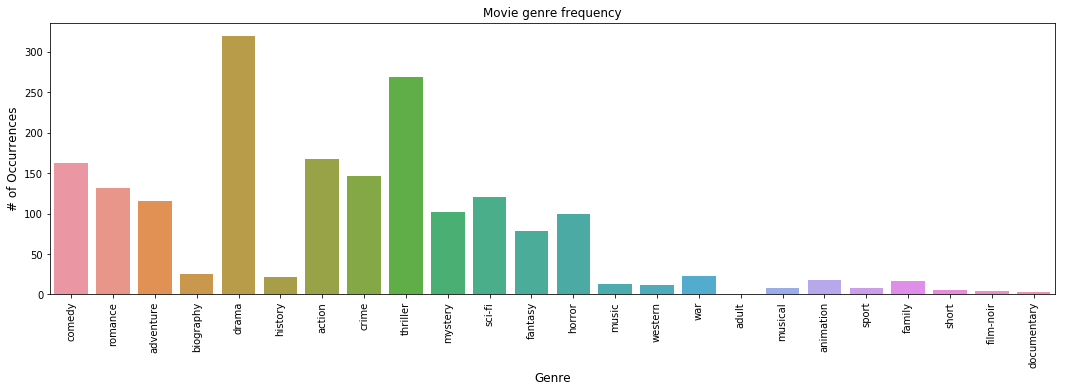

In [11]:
movie_genres = {}
for index, row in movie_meta.iterrows():
    current_genres = eval(row["Genres"])
    for i in range(len(current_genres)):
        if current_genres[i] in movie_genres:
            movie_genres[current_genres[i]] += 1
        else:
            movie_genres[current_genres[i]] = 1
            
genres_stats = {
    "index": [],
    "values": []
}

for genre in movie_genres:
    genres_stats["index"].append(genre)
    genres_stats["values"].append(movie_genres[genre])
            
classes = genres_stats["index"]
        
plt.figure(figsize=(18,5))
plt.xticks(rotation=90)
ax = sns.barplot(genres_stats["index"], genres_stats["values"])
plt.title("Movie genre frequency")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Genre', fontsize=12)

## Data preparation

In [12]:
# Creating a Dataframe with only relevant fields: ID, Lines, Genres spreaded

for label in classes:
    label_array = []
    
    for genre_array in movie_meta.Genres:
        if label in genre_array:
            label_array.append(1)
        else:
            label_array.append(0)
    
    movie_meta[label] = label_array
    
line_dict = {} 

for index, row in movie_lines.iterrows():    
    if row["Movie ID"] in line_dict:
        line_dict[row["Movie ID"]] = str(line_dict[row["Movie ID"]]) + " " + str(row["Line"])
    else:
        line_dict[row["Movie ID"]] = row["Line"]

lines_array = []

for value in line_dict.values():
    lines_array.append(value)   
    
movie_dataframe = pd.DataFrame({ 
    'ID' : movie_meta.ID,
    'Lines' : lines_array
})

for label in classes:
    movie_dataframe[label] = movie_meta[label]


movie_dataframe.head()
    
    

,ID,Lines,comedy,romance,adventure,biography,drama,history,action,crime,...,western,war,adult,musical,animation,sport,family,short,film-noir,documentary
0,m0,They do not! They do to! I hope so. She okay? ...,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,m1,"Can't be that far, I say. Also, I don't like ...",0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,m2,"Officers, there's your killer, do your duty, a...",0,0,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,m3,We're trying to get there. I hope we can. CONT...,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,m4,"Great, just great. That we do. And we put air ...",1,0,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0


## Splitting the Cornell dataset into training and test data

In [13]:
train, test = train_test_split(movie_dataframe, random_state=42, test_size=0.10, shuffle=True)
X_train = train.Lines
X_test = test.Lines
print(X_train.shape)
print(X_test.shape)

(555,)
(62,)


## Comparing different classifier implementation performance: 
## Naive Bayes, SVC and Logistic Regression

In [14]:
# Define a pipeline combining a text feature extractor with multi lable classifier
NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])

SVC_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),
            ])

LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
            ])


scoreNB = []
scoreSVC = []
scoreLog = []

# Catch warnings from the Logistic Regression iterating beyong maxit
with warnings.catch_warnings(record=True) as w:

    for category in classes:
        NB_pipeline.fit(X_train, train[category])
        prediction = NB_pipeline.predict(X_test)
        scoreNB.append(accuracy_score(test[category], prediction))

        SVC_pipeline.fit(X_train, train[category])
        prediction = SVC_pipeline.predict(X_test)
        scoreSVC.append(accuracy_score(test[category], prediction))

        LogReg_pipeline.fit(X_train, train[category])
        prediction = LogReg_pipeline.predict(X_test)
        scoreLog.append(accuracy_score(test[category], prediction))
    
score_df = pd.DataFrame({ 
    'Movie Genre' : classes,
    'Test Accuracy NB' : scoreNB,
    'Test Accuracy SVC': scoreSVC,
    'Test Accuracy Log. Re.': scoreLog
})

score_df

,Movie Genre,Test Accuracy NB,Test Accuracy SVC,Test Accuracy Log. Re.
0,comedy,0.709677,0.758065,0.709677
1,romance,0.741935,0.774194,0.741935
2,adventure,0.870968,0.887097,0.870968
3,biography,0.967742,0.967742,0.967742
4,drama,0.564516,0.758065,0.741935
5,history,0.983871,0.983871,0.983871
6,action,0.806452,0.854839,0.806452
7,crime,0.838710,0.887097,0.838710
8,thriller,0.596774,0.854839,0.709677
9,mystery,0.790323,0.790323,0.790323


## Train the model using the whole dataset and SVC

In [25]:
SVC_trained_pipelines = {}

print("Training model: ", end="", flush=True)

for category in classes:
    print(category + '... ', end="", flush=True)

    SVC_trained_pipelines[category] = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words, ngram_range=(1, 5))),
                ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),
            ])

    SVC_trained_pipelines[category].fit(movie_dataframe.Lines, movie_dataframe[category])

print ("Training done")

Training model: comedy... romance... adventure... biography... drama... history... action... crime... thriller... mystery... sci-fi... fantasy... horror... music... western... war... adult... musical... animation... sport... family... short... film-noir... documentary... Training done


## Predict the genre according to the dialog input:

In [74]:
def scriptUrl(url):
    h = html2text.HTML2Text()
    h.ignore_links = True
    response = urlopen(url)
    html = str(response.read())
    
    return h.handle(html)


# Insert string here and uncomment to use:
# X_test = [""""""]

# Insert url with plain html or txt here and uncomment to use:
# X_test = [scriptUrl("http://www.dailyscript.com/scripts/Men+In+Black.txt")]


# Examples
X_test = ["Is this all you got?"]
# X_test = ["She is behind me, isn't she?"]
# X_test = ["I love you"]
# X_test = ["We’ve got company!"]
# X_test = ["Don’t die on me"]
# X_test = [scriptUrl("http:///www.dailyscript.com/scripts/aboutmary.html")]

predicted = False
for category in classes:
    prediction = SVC_trained_pipelines[category].predict(X_test)
    if prediction == 1:
        predicted = True
        print('The classifier predicts the given corpus to belong to a ' + category + ' movie.')

if not predicted:
    print('The classifier couldn\'t provide a prediction for the given corpus.')


The classifier predicts the given corpus to belong to a crime movie.
The classifier predicts the given corpus to belong to a thriller movie.
